## Transfer Learning mobilenetV2 using Tensorflow

Please download the dataset from the below url

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Nov  1 06:24:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = (224, 224)

train_path = '/content/drive/MyDrive/Lung Cancer/train'
valid_path = '/content/drive/MyDrive/Lung Cancer/val'
test_path = '/content/drive/MyDrive/Lung Cancer/test'

In [5]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Lung Cancer/train/*')
folders

['/content/drive/MyDrive/Lung Cancer/train/Lung benign',
 '/content/drive/MyDrive/Lung Cancer/train/Lung squamous',
 '/content/drive/MyDrive/Lung Cancer/train/Lung adenocarcinoma']

In [6]:
import os
benign_train = len(os.listdir(folders[0]))
squamous_train = len(os.listdir(folders[1]))
adenocarcinoma_train = len(os.listdir(folders[2]))
print(f"No of benign_train files {benign_train}\nNo of squamous_train files {squamous_train}\nNo of adenocarcinoma_train files {adenocarcinoma_train}")

No of benign_train files 3500
No of squamous_train files 3500
No of adenocarcinoma_train files 3500


In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

train_datagen = ImageDataGenerator(rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 10500 images belonging to 3 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 3000 images belonging to 3 classes.


In [9]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 1500 images belonging to 3 classes.


### Model

In [10]:
engine = tf.keras.applications.MobileNetV2(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,
        # Use Imagenet weights
        weights = 'imagenet',
        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),
    )

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x = tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
prediction = Dense(len(folders), activation = 'softmax', name = 'dense_output')(x)
 # Build the Keras model
model = Model(inputs = engine.input, outputs = prediction)

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  # optimizer='adam',
  optimizer= Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
)

Epoch 1/20
329/329 [==============================] - 4255s 13s/step - loss: 0.2034 - accuracy: 0.9284 - val_loss: 14.6966 - val_accuracy: 0.3463 - lr: 0.0010
Epoch 2/20
329/329 [==============================] - 248s 755ms/step - loss: 0.1058 - accuracy: 0.9626 - val_loss: 1.1719 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 3/20
329/329 [==============================] - 246s 747ms/step - loss: 0.0834 - accuracy: 0.9716 - val_loss: 4.4801 - val_accuracy: 0.7443 - lr: 0.0010
Epoch 4/20
329/329 [==============================] - 246s 749ms/step - loss: 0.0768 - accuracy: 0.9728 - val_loss: 0.4822 - val_accuracy: 0.9330 - lr: 0.0010
Epoch 5/20
329/329 [==============================] - 245s 745ms/step - loss: 0.0726 - accuracy: 0.9758 - val_loss: 1.6083 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 6/20
329/329 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9845
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
329/329 [========================

In [16]:
import matplotlib.pyplot as plt

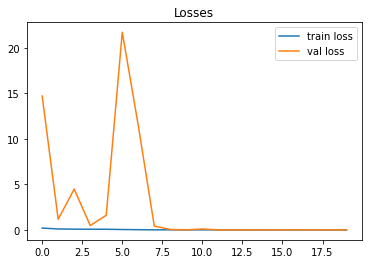

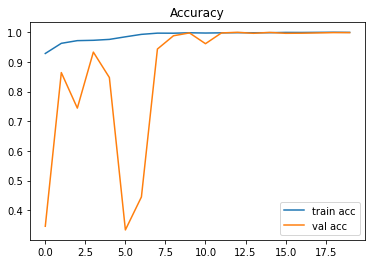

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')
plt.show()
plt.savefig('LossVal_loss')
print()
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [18]:
# average training accuracy
np.mean(r.history['accuracy'])

0.9883714348077774

In [19]:
# val accuracy
model.evaluate(val_set)

94/94 [==============================] - 30s 314ms/step - loss: 0.0049 - accuracy: 0.9987


[0.00485390517860651, 0.9986666440963745]

In [20]:
# test accuracy
model.evaluate(test_set)

47/47 [==============================] - 592s 13s/step - loss: 0.0033 - accuracy: 0.9993


[0.003305128775537014, 0.9993333220481873]

In [23]:
test_set.class_indices

{'Lung adenocarcinoma': 0, 'Lung benign': 1, 'Lung squamous': 2}

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
prob = model.predict(test_set)
print(prob)

47/47 [==============================] - 15s 300ms/step
[[9.8793286e-01 5.3339031e-06 1.2061861e-02]
 [9.7201622e-01 7.8079560e-05 2.7905650e-02]
 [9.9998283e-01 9.6723807e-06 7.5075845e-06]
 ...
 [3.8100399e-07 5.1222089e-09 9.9999964e-01]
 [5.6190558e-08 5.0439408e-10 1.0000000e+00]
 [5.9374867e-07 1.4752104e-08 9.9999940e-01]]


In [24]:
predIdxs = np.argmax(prob, axis=1) 

print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Lung adenocarcinoma','Lung benign','Lung squamous'], digits=5))



                     precision    recall  f1-score   support

Lung adenocarcinoma    1.00000   0.99800   0.99900       500
        Lung benign    1.00000   1.00000   1.00000       500
      Lung squamous    0.99800   1.00000   0.99900       500

           accuracy                        0.99933      1500
          macro avg    0.99933   0.99933   0.99933      1500
       weighted avg    0.99933   0.99933   0.99933      1500



In [25]:

y_true = test_set.labels
y_pred = predIdxs
cm=confusion_matrix(y_true,y_pred)
cm

array([[499,   0,   1],
       [  0, 500,   0],
       [  0,   0, 500]])

Text(69.0, 0.5, 'Predicted Values')

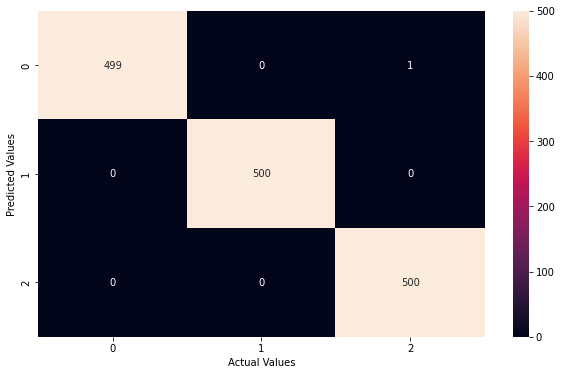

In [26]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [27]:
from sklearn.metrics import accuracy_score, f1_score,matthews_corrcoef,make_scorer, precision_score, recall_score, balanced_accuracy_score
score=accuracy_score(y_true,y_pred)
# scorers = {
#             'f1_score': make_scorer(f1_score, average='micro'),
#             # 'precision_score': make_scorer(precision_score, average='micro'),
#             # 'recall_score': make_scorer(recall_score, average='micro'),
#             'accuracy_score': make_scorer(accuracy_score)
# }
f1 = f1_score(y_true, y_pred,  average='micro')
pre = precision_score(y_true, y_pred,  average='micro')
recall = recall_score(y_true, y_pred,  average='micro')
acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true,y_pred)
# print(f"accuracy {score} f1 {f1} mcc {mcc}")

print(f1, pre, recall, acc,mcc)

0.9993333333333333 0.9993333333333333 0.9993333333333333 0.9993333333333334 0.9990006660006661


In [28]:
# # save it as a h5 file
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('Transfer_Learning_covid_mobilenetV2.h5')

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('/content/lung cancer_mobilenetV2.h5')

In [30]:
img=image.load_img('/content/drive/MyDrive/Lung Cancer/test/Lung squamous/lungscc1000.jpeg',target_size=(224,224))
x=image.img_to_array(img)
x=x/255
x.shape

(224, 224, 3)

In [ ]:
# # from keras.applications.xception import preprocess_input
# import numpy as np
# x=np.expand_dims(x,axis=0)
# img_data=preprocess_input(x)
# img_data.shape

In [31]:
img_data = x.reshape(1,224,224,3)

In [32]:
result = model.predict(img_data)
result = np.argmax(result, axis=-1)
result

1/1 [==============================] - 1s 972ms/step


array([2])

In [33]:
a=np.argmax(model.predict(img_data), axis=1)
a

1/1 [==============================] - 0s 19ms/step


array([2])